<a href="https://colab.research.google.com/github/rounak-roy-2025/Finance101/blob/rounak-roy-2025-qf/VIXTest01ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.interpolate import interp1d
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

In [40]:
class NIFTYVIXStressTest:
    """Comprehensive NIFTY VIX assumptions testing framework"""

    def __init__(self, option_data, spot_data, vix_data=None):
        self.options = option_data.copy()
        self.spot = spot_data.copy()
        self.vix = vix_data.copy() if vix_data is not None else None

        # Ensure datetime formats
        self.options['date'] = pd.to_datetime(self.options['date'])
        self.options['expiry'] = pd.to_datetime(self.options['expiry'])
        self.spot['date'] = pd.to_datetime(self.spot['date'])

        # Merge spot prices
        self.options = self.options.merge(self.spot, on='date', how='left')

        # Calculate basic metrics
        self._calculate_derived_metrics()

    def _calculate_derived_metrics(self):
        """Calculate moneyness, mid-price, spread, and days to expiry"""
        # Mid price
        self.options['mid_price'] = (self.options['bid'] + self.options['ask']) / 2

        # Bid-ask spread
        self.options['spread'] = self.options['ask'] - self.options['bid']
        self.options['spread_pct'] = (self.options['spread'] / self.options['mid_price']) * 100

        # Days to expiry
        self.options['dte'] = (self.options['expiry'] - self.options['date']).dt.days

        # Moneyness
        self.options['moneyness'] = (self.options['strike'] - self.options['spot_price']) / self.options['spot_price']
        self.options['moneyness_pct'] = self.options['moneyness'] * 100

        # ATM distance
        self.options['atm_distance'] = np.abs(self.options['strike'] - self.options['spot_price'])

        # Total liquidity metric
        self.options['total_liquidity'] = self.options['volume'] + self.options['open_interest']

    def test_1_atm_liquidity_clustering(self, moneyness_bins=None, figsize=(15, 10)):
        """
        Step 1: ATM-Centered Liquidity Clustering Test
        Tests assumption of smooth option price curve across strikes
        """
        print("=" * 80)
        print("TEST 1: ATM-CENTERED LIQUIDITY CLUSTERING")
        print("=" * 80)

        if moneyness_bins is None:
            moneyness_bins = np.arange(-0.20, 0.21, 0.01)  # -20% to +20% in 1% buckets

        # Aggregate by moneyness bucket
        self.options['moneyness_bucket'] = pd.cut(
            self.options['moneyness'],
            bins=moneyness_bins,
            labels=moneyness_bins[:-1]
        )

        liquidity_profile = self.options.groupby('moneyness_bucket').agg({
            'volume': 'sum',
            'open_interest': 'sum',
            'total_liquidity': 'sum'
        }).reset_index()

        liquidity_profile['moneyness_pct'] = liquidity_profile['moneyness_bucket'].astype(float) * 100

        # Calculate liquidity concentration
        total_liq = liquidity_profile['total_liquidity'].sum()
        liq_5pct = liquidity_profile[
            liquidity_profile['moneyness_pct'].abs() <= 5
        ]['total_liquidity'].sum()
        liq_10pct = liquidity_profile[
            liquidity_profile['moneyness_pct'].abs() <= 10
        ]['total_liquidity'].sum()

        concentration_5 = (liq_5pct / total_liq) * 100
        concentration_10 = (liq_10pct / total_liq) * 100

        print(f"\nLiquidity Concentration:")
        print(f"  Within ±5% moneyness:  {concentration_5:.1f}%")
        print(f"  Within ±10% moneyness: {concentration_10:.1f}%")
        print(f"  Beyond ±10% moneyness: {100 - concentration_10:.1f}%")

        # Visualization
        fig, axes = plt.subplots(2, 2, figsize=figsize)

        # Plot 1: Total Liquidity
        ax1 = axes[0, 0]
        ax1.bar(liquidity_profile['moneyness_pct'],
                liquidity_profile['total_liquidity'],
                width=0.8, alpha=0.7, color='steelblue')
        ax1.axvline(x=-5, color='red', linestyle='--', alpha=0.5, label='±5% boundary')
        ax1.axvline(x=5, color='red', linestyle='--', alpha=0.5)
        ax1.axvline(x=-10, color='orange', linestyle='--', alpha=0.5, label='±10% boundary')
        ax1.axvline(x=10, color='orange', linestyle='--', alpha=0.5)
        ax1.set_xlabel('Moneyness (%)')
        ax1.set_ylabel('Total Liquidity (Volume + OI)')
        ax1.set_title('Liquidity Distribution Across Moneyness')
        ax1.legend()
        ax1.grid(alpha=0.3)

        # Plot 2: Volume vs Open Interest
        ax2 = axes[0, 1]
        ax2.plot(liquidity_profile['moneyness_pct'],
                liquidity_profile['volume'],
                marker='o', label='Volume', alpha=0.7)
        ax2.plot(liquidity_profile['moneyness_pct'],
                liquidity_profile['open_interest'],
                marker='s', label='Open Interest', alpha=0.7)
        ax2.axvline(x=0, color='black', linestyle='-', alpha=0.3)
        ax2.set_xlabel('Moneyness (%)')
        ax2.set_ylabel('Count')
        ax2.set_title('Volume vs Open Interest by Moneyness')
        ax2.legend()
        ax2.grid(alpha=0.3)

        # Plot 3: Liquidity Decay (Log Scale)
        ax3 = axes[1, 0]
        ax3.semilogy(liquidity_profile['moneyness_pct'],
                     liquidity_profile['total_liquidity'],
                     marker='o', alpha=0.7, color='steelblue')
        ax3.axvline(x=-5, color='red', linestyle='--', alpha=0.5)
        ax3.axvline(x=5, color='red', linestyle='--', alpha=0.5)
        ax3.set_xlabel('Moneyness (%)')
        ax3.set_ylabel('Total Liquidity (Log Scale)')
        ax3.set_title('Liquidity Decay Pattern (Log Scale)')
        ax3.grid(alpha=0.3)

        # Plot 4: Cumulative Distribution
        ax4 = axes[1, 1]
        sorted_liq = liquidity_profile.sort_values('moneyness_pct')
        sorted_liq['cumulative_pct'] = (sorted_liq['total_liquidity'].cumsum() /
                                        sorted_liq['total_liquidity'].sum() * 100)
        ax4.plot(sorted_liq['moneyness_pct'],
                sorted_liq['cumulative_pct'],
                marker='o', alpha=0.7, color='darkgreen')
        ax4.axhline(y=50, color='red', linestyle='--', alpha=0.5, label='50% threshold')
        ax4.axhline(y=80, color='orange', linestyle='--', alpha=0.5, label='80% threshold')
        ax4.set_xlabel('Moneyness (%)')
        ax4.set_ylabel('Cumulative Liquidity (%)')
        ax4.set_title('Cumulative Liquidity Distribution')
        ax4.legend()
        ax4.grid(alpha=0.3)

        plt.tight_layout()
        plt.savefig('test1_atm_liquidity_clustering.png', dpi=300, bbox_inches='tight')
        plt.show()

        print(f"\n✓ Evidence: {concentration_5:.1f}% of liquidity within ±5% moneyness")
        print(f"  → Strike smoothness assumption {'WEAK' if concentration_5 > 70 else 'MODERATE'} beyond ATM region\n")

        return liquidity_profile

    def test_2_otm_liquidity_quality(self, moneyness_thresholds=[5, 10, 15], figsize=(15, 8)):
        """
        OTM Liquidity Quality Test
        Tests deep OTM liquidity reliability via bid-ask spreads
        """
        print("=" * 80)
        print("TEST 2: OTM LIQUIDITY QUALITY")
        print("=" * 80)

        # Filter valid spreads
        valid_data = self.options[
            (self.options['mid_price'] > 0) &
            (self.options['spread'] >= 0)
        ].copy()

        # Categorize by moneyness
        valid_data['moneyness_category'] = pd.cut(
            valid_data['moneyness_pct'].abs(),
            bins=[0, 5, 10, 15, 100],
            labels=['ATM (0-5%)', 'Near OTM (5-10%)', 'Mid OTM (10-15%)', 'Deep OTM (>15%)']
        )
        # Calculate spread statistics
        spread_stats = valid_data.groupby('moneyness_category').agg({
            'spread_pct': ['mean', 'median', 'std'],
            'strike': 'count'
        }).round(2)

        print("\nBid-Ask Spread Analysis by Moneyness:")
        print(spread_stats)

        atm_median = valid_data[valid_data['moneyness_pct'].abs() <= 5]['spread_pct'].median()
        deep_otm_median = valid_data[valid_data['moneyness_pct'].abs() > 15]['spread_pct'].median()
        spread_inflation = (deep_otm_median / atm_median) if atm_median > 0 else np.inf

        print(f"\nSpread Inflation Factor (Deep OTM / ATM): {spread_inflation:.2f}x")

        # Visualization
        fig, axes = plt.subplots(2, 2, figsize=figsize)

        # Plot 1: Spread vs Moneyness (Scatter)
        ax1 = axes[0, 0]
        scatter_sample = valid_data.sample(min(5000, len(valid_data)))
        ax1.scatter(scatter_sample['moneyness_pct'],
                   scatter_sample['spread_pct'],
                   alpha=0.3, s=10)
        ax1.axvline(x=-5, color='red', linestyle='--', alpha=0.5)
        ax1.axvline(x=5, color='red', linestyle='--', alpha=0.5)
        ax1.set_xlabel('Moneyness (%)')
        ax1.set_ylabel('Bid-Ask Spread (%)')
        ax1.set_title('Spread Inflation Across Moneyness')
        ax1.set_ylim([0, valid_data['spread_pct'].quantile(0.95)])
        ax1.grid(alpha=0.3)

        # Plot 2: Box Plot by Category
        ax2 = axes[0, 1]
        valid_data.boxplot(column='spread_pct', by='moneyness_category', ax=ax2)
        ax2.set_xlabel('Moneyness Category')
        ax2.set_ylabel('Bid-Ask Spread (%)')
        ax2.set_title('Spread Distribution by Category')
        ax2.get_figure().suptitle('')
        plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

        # Plot 3: Binned Spread Analysis
        ax3 = axes[1, 0]
        bins = np.arange(-20, 21, 2)
        valid_data['moneyness_bin'] = pd.cut(valid_data['moneyness_pct'], bins=bins)
        binned_spreads = valid_data.groupby('moneyness_bin')['spread_pct'].median()
        bin_centers = [(bins[i] + bins[i+1])/2 for i in range(len(bins)-1)]
        ax3.plot(bin_centers, binned_spreads.values, marker='o', alpha=0.7)
        ax3.axvline(x=-5, color='red', linestyle='--', alpha=0.5)
        ax3.axvline(x=5, color='red', linestyle='--', alpha=0.5)
        ax3.set_xlabel('Moneyness (%)')
        ax3.set_ylabel('Median Spread (%)')
        ax3.set_title('Median Spread by Moneyness Bin')
        ax3.grid(alpha=0.3)

        # Plot 4: Spread vs Liquidity
        ax4 = axes[1, 1]
        liquidity_bins = pd.qcut(valid_data['total_liquidity'], q=10, duplicates='drop')
        spread_by_liq = valid_data.groupby(liquidity_bins)['spread_pct'].median()
        ax4.plot(range(len(spread_by_liq)), spread_by_liq.values, marker='o', alpha=0.7)
        ax4.set_xlabel('Liquidity Decile (Low to High)')
        ax4.set_ylabel('Median Spread (%)')
        ax4.set_title('Spread vs Liquidity Level')
        ax4.grid(alpha=0.3)

        plt.tight_layout()
        plt.savefig('test2_otm_liquidity_quality.png', dpi=300, bbox_inches='tight')
        plt.show()

        print(f"\n✓ Evidence: {spread_inflation:.1f}x spread inflation in deep OTM")
        print(f"  → Noisy inputs into variance estimation from OTM region\n")

        return spread_stats

    def test_3_strike_continuity_gaps(self, figsize=(15, 10)):
        """
        Step 3: Strike Continuity Gap Detection
        Tests continuous strike availability assumption
        """
        print("=" * 80)
        print("TEST 3: STRIKE CONTINUITY GAP DETECTION")
        print("=" * 80)

        gap_results = []

        for (date, expiry), group in self.options.groupby(['date', 'expiry']):
            spot = group['spot_price'].iloc[0]
            strikes_sorted = sorted(group['strike'].unique())

            if len(strikes_sorted) > 1:
                gaps = np.diff(strikes_sorted)
                gaps_normalized = gaps / spot

                for i, gap in enumerate(gaps):
                    gap_results.append({
                        'date': date,
                        'expiry': expiry,
                        'dte': group['dte'].iloc[0],
                        'strike_lower': strikes_sorted[i],
                        'strike_upper': strikes_sorted[i+1],
                        'gap_absolute': gap,
                        'gap_normalized': gaps_normalized[i],
                        'gap_pct': gaps_normalized[i] * 100,
                        'moneyness_center': ((strikes_sorted[i] + strikes_sorted[i+1])/2 - spot) / spot * 100
                    })

        gaps_df = pd.DataFrame(gap_results)

        # Statistics
        print(f"\nStrike Gap Statistics:")
        print(f"  Mean gap: {gaps_df['gap_pct'].mean():.3f}%")
        print(f"  Median gap: {gaps_df['gap_pct'].median():.3f}%")
        print(f"  Std dev: {gaps_df['gap_pct'].std():.3f}%")
        print(f"  Max gap: {gaps_df['gap_pct'].max():.3f}%")
        print(f"  Gaps > 1%: {(gaps_df['gap_pct'] > 1).sum()} ({(gaps_df['gap_pct'] > 1).mean()*100:.1f}%)")
        print(f"  Gaps > 2%: {(gaps_df['gap_pct'] > 2).sum()} ({(gaps_df['gap_pct'] > 2).mean()*100:.1f}%)")

        # Visualization
        fig, axes = plt.subplots(2, 2, figsize=figsize)

        # Plot 1: Gap distribution
        ax1 = axes[0, 0]
        ax1.hist(gaps_df['gap_pct'], bins=50, alpha=0.7, edgecolor='black')
        ax1.axvline(x=gaps_df['gap_pct'].median(), color='red',
                   linestyle='--', label=f"Median: {gaps_df['gap_pct'].median():.2f}%")
        ax1.set_xlabel('Strike Gap (% of Spot)')
        ax1.set_ylabel('Frequency')
        ax1.set_title('Distribution of Strike Gaps')
        ax1.legend()
        ax1.grid(alpha=0.3)

        # Plot 2: Gap vs Moneyness
        ax2 = axes[0, 1]
        scatter_sample = gaps_df.sample(min(2000, len(gaps_df)))
        ax2.scatter(scatter_sample['moneyness_center'],
                   scatter_sample['gap_pct'],
                   alpha=0.3, s=10)
        ax2.axvline(x=-5, color='red', linestyle='--', alpha=0.5)
        ax2.axvline(x=5, color='red', linestyle='--', alpha=0.5)
        ax2.set_xlabel('Moneyness (%)')
        ax2.set_ylabel('Gap Size (% of Spot)')
        ax2.set_title('Strike Gaps Across Moneyness')
        ax2.set_ylim([0, gaps_df['gap_pct'].quantile(0.95)])
        ax2.grid(alpha=0.3)

        # Plot 3: Strike density heatmap
        ax3 = axes[1, 0]
        strike_density = gaps_df.groupby(
            pd.cut(gaps_df['moneyness_center'], bins=np.arange(-20, 21, 1))
        )['gap_pct'].agg(['mean', 'count'])
        strike_density_valid = strike_density[strike_density['count'] > 5]
        ax3.bar(range(len(strike_density_valid)),
               strike_density_valid['mean'],
               alpha=0.7, color='coral')
        ax3.set_xlabel('Moneyness Bucket')
        ax3.set_ylabel('Average Gap (%)')
        ax3.set_title('Strike Density by Moneyness Region')
        ax3.grid(alpha=0.3)

        # Plot 4: Gap vs DTE
        ax4 = axes[1, 1]
        dte_bins = [0, 7, 15, 30, 60, 365]
        gaps_df['dte_bucket'] = pd.cut(gaps_df['dte'], bins=dte_bins)
        gap_by_dte = gaps_df.groupby('dte_bucket')['gap_pct'].mean()
        ax4.bar(range(len(gap_by_dte)), gap_by_dte.values, alpha=0.7)
        ax4.set_xticks(range(len(gap_by_dte)))
        ax4.set_xticklabels([str(x) for x in gap_by_dte.index], rotation=45)
        ax4.set_xlabel('Days to Expiry')
        ax4.set_ylabel('Average Gap (%)')
        ax4.set_title('Strike Gaps by Expiry Tenor')
        ax4.grid(alpha=0.3)

        plt.tight_layout()
        plt.savefig('test3_strike_continuity_gaps.png', dpi=300, bbox_inches='tight')
        plt.show()

        print(f"\n✓ Evidence: Discrete strike grid with irregular spacing")
        print(f"  → Imperfect variance replication from discrete approximation\n")

        return gaps_df

    def test_4_short_dated_volume_dominance(self, figsize=(15, 8)):
        """
        Step 4: Short-Dated Volume Dominance Test
        Identifies event-driven and short-term distortions
        """
        print("=" * 80)
        print("TEST 4: SHORT-DATED VOLUME DOMINANCE")
        print("=" * 80)

        # Classify by DTE
        self.options['dte_category'] = pd.cut(
            self.options['dte'],
            bins=[0, 7, 30, 365],
            labels=['0-7 DTE', '8-30 DTE', '>30 DTE']
        )

        # Daily volume by category
        daily_volume = self.options.groupby(['date', 'dte_category'])['volume'].sum().unstack(fill_value=0)
        daily_volume['total'] = daily_volume.sum(axis=1)

        for col in ['0-7 DTE', '8-30 DTE', '>30 DTE']:
            daily_volume[f'{col}_pct'] = (daily_volume[col] / daily_volume['total']) * 100

        # Statistics
        print("\nVolume Distribution by DTE Category:")
        print(f"  0-7 DTE:   {daily_volume['0-7 DTE_pct'].mean():.1f}% (±{daily_volume['0-7 DTE_pct'].std():.1f}%)")
        print(f"  8-30 DTE:  {daily_volume['8-30 DTE_pct'].mean():.1f}% (±{daily_volume['8-30 DTE_pct'].std():.1f}%)")
        print(f"  >30 DTE:   {daily_volume['>30 DTE_pct'].mean():.1f}% (±{daily_volume['>30 DTE_pct'].std():.1f}%)")

        short_dated_dominance = daily_volume['0-7 DTE_pct'].mean()

        # Visualization
        fig, axes = plt.subplots(2, 2, figsize=figsize)

        # Plot 1: Stacked area chart
        ax1 = axes[0, 0]
        ax1.fill_between(daily_volume.index, 0, daily_volume['0-7 DTE_pct'],
                        alpha=0.7, label='0-7 DTE')
        ax1.fill_between(daily_volume.index,
                        daily_volume['0-7 DTE_pct'],
                        daily_volume['0-7 DTE_pct'] + daily_volume['8-30 DTE_pct'],
                        alpha=0.7, label='8-30 DTE')
        ax1.fill_between(daily_volume.index,
                        daily_volume['0-7 DTE_pct'] + daily_volume['8-30 DTE_pct'],
                        100, alpha=0.7, label='>30 DTE')
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Volume Share (%)')
        ax1.set_title('Volume Dominance Regimes Over Time')
        ax1.legend()
        ax1.grid(alpha=0.3)

        # Plot 2: Box plot
        ax2 = axes[0, 1]
        volume_pcts = daily_volume[['0-7 DTE_pct', '8-30 DTE_pct', '>30 DTE_pct']]
        volume_pcts.boxplot(ax=ax2)
        ax2.set_ylabel('Volume Share (%)')
        ax2.set_title('Volume Distribution by DTE Category')
        ax2.grid(alpha=0.3)

        # Plot 3: Rolling average
        ax3 = axes[1, 0]
        for col in ['0-7 DTE_pct', '8-30 DTE_pct', '>30 DTE_pct']:
            ax3.plot(daily_volume.index,
                    daily_volume[col].rolling(window=5).mean(),
                    label=col, alpha=0.7, linewidth=2)
        ax3.set_xlabel('Date')
        ax3.set_ylabel('Volume Share (%) - 5D MA')
        ax3.set_title('Smoothed Volume Dominance Trends')
        ax3.legend()
        ax3.grid(alpha=0.3)

        # Plot 4: Regime detection
        ax4 = axes[1, 1]
        daily_volume['short_dominant'] = daily_volume['0-7 DTE_pct'] > 50
        regime_counts = daily_volume['short_dominant'].value_counts()
        ax4.bar(['Normal\nRegime', 'Short-Dated\nDominant'],
               [regime_counts.get(False, 0), regime_counts.get(True, 0)],
               color=['steelblue', 'coral'], alpha=0.7)
        ax4.set_ylabel('Number of Days')
        ax4.set_title('Trading Regime Classification')
        ax4.grid(alpha=0.3)

        plt.tight_layout()
        plt.savefig('test4_short_dated_dominance.png', dpi=300, bbox_inches='tight')
        plt.show()

        print(f"\n✓ Evidence: {short_dated_dominance:.1f}% average volume in 0-7 DTE")
        print(f"  → Variance reflects short-term positioning, not long-horizon risk\n")

        return daily_volume

    def test_5_synthetic_variance_reconstruction(self, target_dte=30, risk_free_rate=0.05,
                                                   figsize=(15, 10)):
        """
        Step 5: Synthetic Variance Reconstruction vs NIFTY VIX
        Quantifies gap between theory and reported index
        """
        print("=" * 80)
        print("TEST 5: SYNTHETIC VARIANCE RECONSTRUCTION")
        print("=" * 80)

        reconstruction_results = []

        for date in self.options['date'].unique():
            try:
                # Get data for this date
                day_data = self.options[self.options['date'] == date].copy()
                spot = day_data['spot_price'].iloc[0]

                # Find nearest expiry to target DTE
                expiries = day_data.groupby('expiry')['dte'].first().sort_values()
                if len(expiries) < 2:
                    continue

                # Get near and next term expiries
                near_term = expiries.iloc[0]
                next_term = expiries.iloc[1] if len(expiries) > 1 else expiries.iloc[0]

                near_data = day_data[day_data['expiry'] == expiries.index[0]]

                # Calculate synthetic variance for near term
                variance = self._calculate_vix_variance(near_data, spot, near_term/365, risk_free_rate)

                if variance is not None and variance > 0:
                    implied_vol = np.sqrt(variance) * 100  # Annualized %

                    result = {
                        'date': date,
                        'dte': near_term,
                        'synthetic_vix': implied_vol,
                        'num_strikes': len(near_data)
                    }

                    # Add official VIX if available
                    if self.vix is not None:
                        official = self.vix[self.vix['date'] == date]
                        if len(official) > 0:
                            result['official_vix'] = official['nifty_vix'].iloc[0]
                            result['error'] = implied_vol - official['nifty_vix'].iloc[0]
                            result['error_pct'] = (result['error'] / official['nifty_vix'].iloc[0]) * 100

                    reconstruction_results.append(result)
            except Exception as e:
                continue

        results_df = pd.DataFrame(reconstruction_results)

        if len(results_df) == 0:
            print("⚠ Insufficient data for variance reconstruction")
            return None

        print(f"\nSuccessfully reconstructed variance for {len(results_df)} days")
        print(f"Mean synthetic VIX: {results_df['synthetic_vix'].mean():.2f}")
        print(f"Std synthetic VIX: {results_df['synthetic_vix'].std():.2f}")

        if 'error' in results_df.columns:
            print(f"\nReconstruction Error vs Official VIX:")
            print(f"  Mean error: {results_df['error'].mean():.2f} pts")
            print(f"  Mean abs error: {results_df['error'].abs().mean():.2f} pts")
            print(f"  RMSE: {np.sqrt((results_df['error']**2).mean()):.2f} pts")
            print(f"  Correlation: {results_df['synthetic_vix'].corr(results_df['official_vix']):.3f}")

        # Visualization
        fig, axes = plt.subplots(2, 2, figsize=figsize)

        # Plot 1: Time series comparison
        ax1 = axes[0, 0]
        ax1.plot(results_df['date'], results_df['synthetic_vix'],
                label='Synthetic VIX', alpha=0.7, linewidth=2)
        if 'official_vix' in results_df.columns:
            ax1.plot(results_df['date'], results_df['official_vix'],
                    label='Official VIX', alpha=0.7, linewidth=2, linestyle='--')
        ax1.set_xlabel('Date')
        ax1.set_ylabel('VIX Level')
        ax1.set_title('Synthetic vs Official VIX')
        ax1.legend()
        ax1.grid(alpha=0.3)

        # Plot 2: Scatter plot
        if 'official_vix' in results_df.columns:
            ax2 = axes[0, 1]
            ax2.scatter(results_df['official_vix'], results_df['synthetic_vix'],
                       alpha=0.5, s=30)
            min_val = min(results_df['official_vix'].min(), results_df['synthetic_vix'].min())
            max_val = max(results_df['official_vix'].max(), results_df['synthetic_vix'].max())
            ax2.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect fit')
            ax2.set_xlabel('Official VIX')
            ax2.set_ylabel('Synthetic VIX')
            ax2.set_title('Reconstruction Accuracy')
            ax2.legend()
            ax2.grid(alpha=0.3)

        # Plot 3: Error distribution
        if 'error' in results_df.columns:
            ax3 = axes[1, 0]
            ax3.hist(results_df['error'], bins=30, alpha=0.7, edgecolor='black')
            ax3.axvline(x=0, color='red', linestyle='--', linewidth=2)
            ax3.axvline(x=results_df['error'].mean(), color='orange',
                       linestyle='--', label=f"Mean: {results_df['error'].mean():.2f}")
            ax3.set_xlabel('Error (Synthetic - Official)')
            ax3.set_ylabel('Frequency')
            ax3.set_title('Reconstruction Error Distribution')
            ax3.legend()
            ax3.grid(alpha=0.3)

        # Plot 4: Error over time
        if 'error' in results_df.columns:
            ax4 = axes[1, 1]
            ax4.plot(results_df['date'], results_df['error'], alpha=0.7)
            ax4.axhline(y=0, color='red', linestyle='--')
            ax4.fill_between(results_df['date'], 0, results_df['error'],
                           alpha=0.3, where=(results_df['error'] > 0), color='green')
            ax4.fill_between(results_df['date'], 0, results_df['error'],
                           alpha=0.3, where=(results_df['error'] < 0), color='red')
            ax4.set_xlabel('Date')
            ax4.set_ylabel('Error (pts)')
            ax4.set_title('Reconstruction Error Over Time')
            ax4.grid(alpha=0.3)

        plt.tight_layout()
        plt.savefig('test5_variance_reconstruction.png', dpi=300, bbox_inches='tight')
        plt.show()

        if 'error' in results_df.columns:
            print(f"\n✓ Evidence: Persistent deviation detected")
            print(f"  → Gap between theoretical VIX formula and reported index\n")

        return results_df

    def _calculate_vix_variance(self, option_data, spot, T, r):
        """
        Calculate VIX-style variance using available strikes
        """
        try:
            # Filter liquid options
            liquid = option_data[
                (option_data['volume'] > 0) | (option_data['open_interest'] > 0)
            ].copy()

            if len(liquid) < 5:
                return None

            # Get put and call data
            puts = liquid[liquid['option_type'] == 'PE'].sort_values('strike')
            calls = liquid[liquid['option_type'] == 'CE'].sort_values('strike')

            if len(puts) < 2 or len(calls) < 2:
                return None

            # Find ATM strike
            atm_strike = min(liquid['strike'].unique(), key=lambda x: abs(x - spot))

            # Combine OTM options
            otm_puts = puts[puts['strike'] < atm_strike]
            otm_calls = calls[calls['option_type'] == 'CE']
            otm_calls = otm_calls[otm_calls['strike'] > atm_strike]
            atm_options = liquid[liquid['strike'] == atm_strike]

            # Concatenate puts, ATM, and calls for variance calculation
            options_for_vix = pd.concat([otm_puts, atm_options, otm_calls])

            if len(options_for_vix) < 2: # Need at least 2 strikes for meaningful calculation
                return None

            # Calculate contribution from each strike
            variance_sum = 0
            strikes_sorted = sorted(options_for_vix['strike'].unique())

            for i, K in enumerate(strikes_sorted):
                options_at_K = options_for_vix[options_for_vix['strike'] == K]
                if options_at_K.empty: # Should not happen with current logic, but as safeguard
                    continue

                # Get the mid-price for the specific strike K
                # For ATM strike, we usually use the average of CE and PE closest to money
                # For OTMs, just use the relevant option type
                price = options_at_K['mid_price'].mean() # Using mean for safety if multiple options for same strike

                # Calculate strike interval dK
                if i == 0: # First strike
                    dK = strikes_sorted[1] - strikes_sorted[0]
                elif i == len(strikes_sorted) - 1: # Last strike
                    dK = strikes_sorted[i] - strikes_sorted[i-1]
                else: # Intermediate strikes
                    dK = (strikes_sorted[i+1] - strikes_sorted[i-1]) / 2

                # VIX formula contribution
                contribution = (dK / K**2) * np.exp(r * T) * price
                variance_sum += contribution

            variance = (2 / T) * variance_sum

            # Adjust for forward-ATM difference
            F = spot * np.exp(r * T)
            # Use the ATM strike in the calculation. If there's an exact ATM strike, use it. Otherwise, find the closest one.
            # The atm_strike was already found above, so reuse it.
            variance -= (1 / T) * ((F / atm_strike) - 1)**2

            return max(variance, 0)

        except Exception as e:
            # print(f"Error calculating VIX variance for date: {option_data['date'].iloc[0].date()}, Error: {e}")
            return None

    def test_6_realized_volatility_forecast(self, forecast_window=30, figsize=(15, 10)):
        """
        Step 6: Realized Volatility Forecast Error Test
        Tests whether NIFTY VIX forecasts realized volatility effectively
        """
        print("=" * 80)
        print("TEST 6: REALIZED VOLATILITY FORECAST ERROR")
        print("=" * 80)

        if self.vix is None:
            print("⚠ Official VIX data required for this test")
            return None

        # Calculate realized volatility
        self.spot['returns'] = np.log(self.spot['spot_price'] / self.spot['spot_price'].shift(1))
        self.spot[f'realized_vol_{forecast_window}d'] = (
            self.spot['returns'].rolling(window=forecast_window).std() * np.sqrt(252) * 100
        )

        # Merge VIX with realized vol
        analysis_df = self.vix.merge(self.spot[['date', f'realized_vol_{forecast_window}d']],
                                     on='date', how='inner')
        analysis_df['forecast_error'] = analysis_df['nifty_vix'] - analysis_df[f'realized_vol_{forecast_window}d']

        # Add short-dated dominance flag
        daily_vol = self.options.groupby(['date', 'dte']).agg({'volume': 'sum'}).reset_index()
        short_dated_vol = daily_vol[daily_vol['dte'] <= 7].groupby('date')['volume'].sum()
        total_vol = daily_vol.groupby('date')['volume'].sum()
        short_dated_pct = (short_dated_vol / total_vol * 100).to_frame('short_dated_pct')

        analysis_df = analysis_df.merge(short_dated_pct, left_on='date', right_index=True, how='left')
        # Fill NaN short_dated_pct with 0, meaning no short-dated volume for that day
        analysis_df['short_dated_pct'] = analysis_df['short_dated_pct'].fillna(0)

        analysis_df['regime'] = analysis_df['short_dated_pct'].apply(
            lambda x: 'High Short-Dated' if x > 50 else 'Normal'
        )

        # Statistics
        print(f"\nForecast Error Analysis:")
        print(f"  Mean error: {analysis_df['forecast_error'].mean():.2f} pts")
        print(f"  MAE: {analysis_df['forecast_error'].abs().mean():.2f} pts")
        print(f"  RMSE: {np.sqrt((analysis_df['forecast_error']**2).mean()):.2f} pts")
        print(f"  Correlation (Implied vs Realized): {analysis_df['nifty_vix'].corr(analysis_df[f'realized_vol_{forecast_window}d']):.3f}")

        # Compare regimes
        regime_stats = analysis_df.groupby('regime')['forecast_error'].agg([
            'mean', 'std', lambda x: x.abs().mean()
        ]).round(2)
        regime_stats.columns = ['Mean Error', 'Std Error', 'MAE']

        print(f"\nForecast Error by Regime:")
        print(regime_stats)

        # Determine comparison text based on available regimes
        comparison_text = "" # Default to empty string
        if 'High Short-Dated' in regime_stats.index and 'Normal' in regime_stats.index:
            comparison_text = 'Higher' if regime_stats.loc['High Short-Dated', 'MAE'] > regime_stats.loc['Normal', 'MAE'] else 'Similar'
        elif 'High Short-Dated' in regime_stats.index:
            comparison_text = 'Only High Short-Dated regime observed'
        elif 'Normal' in regime_stats.index:
            comparison_text = 'Only Normal regime observed'
        else:
            comparison_text = 'No regimes observed'

        print(f"\n✓ Evidence: {comparison_text} forecast errors during event-driven regimes")
        print(f"  → VIX predictive power varies with market microstructure\n")

        # Statistical test
        normal_errors = analysis_df[analysis_df['regime'] == 'Normal']['forecast_error'].dropna()
        event_errors = analysis_df[analysis_df['regime'] == 'High Short-Dated']['forecast_error'].dropna()

        if len(normal_errors) > 0 and len(event_errors) > 0:
            t_stat, p_value = stats.ttest_ind(normal_errors, event_errors)
            print(f"\nT-test (Normal vs Event-Driven):")
            print(f"  t-statistic: {t_stat:.3f}")
            print(f"  p-value: {p_value:.4f}")
        else:
            print(f"\nSkipping T-test: Insufficient data for one or both regimes ('Normal': {len(normal_errors)}, 'High Short-Dated': {len(event_errors)})")

        # Visualization
        fig, axes = plt.subplots(2, 2, figsize=figsize)

        # Plot 1: Implied vs Realized
        ax1 = axes[0, 0]
        ax1.scatter(analysis_df[f'realized_vol_{forecast_window}d'],
                   analysis_df['nifty_vix'],
                   alpha=0.5, s=30)
        min_val = min(analysis_df[f'realized_vol_{forecast_window}d'].min(),
                     analysis_df['nifty_vix'].min())
        max_val = max(analysis_df[f'realized_vol_{forecast_window}d'].max(),
                     analysis_df['nifty_vix'].max())
        ax1.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect forecast')
        ax1.set_xlabel('Realized Volatility (%)')
        ax1.set_ylabel('NIFTY VIX (%)')
        ax1.set_title('Implied vs Realized Volatility')
        ax1.legend()
        ax1.grid(alpha=0.3)

        # Plot 2: Time series
        ax2 = axes[0, 1]
        ax2.plot(analysis_df['date'], analysis_df['nifty_vix'],
                label='Implied (VIX)', alpha=0.7, linewidth=2)
        ax2.plot(analysis_df['date'], analysis_df[f'realized_vol_{forecast_window}d'],
                label=f'Realized ({forecast_window}d)', alpha=0.7, linewidth=2, linestyle='--')
        ax2.set_xlabel('Date')
        ax2.set_ylabel('Volatility (%)')
        ax2.set_title('Implied vs Realized Volatility Over Time')
        ax2.legend()
        ax2.grid(alpha=0.3)

        # Plot 3: Error distribution by regime
        ax3 = axes[1, 0]
        for regime in ['Normal', 'High Short-Dated']:
            regime_data = analysis_df[analysis_df['regime'] == regime]['forecast_error'].dropna()
            if len(regime_data) > 0:
                ax3.hist(regime_data, bins=20, alpha=0.5, label=regime, edgecolor='black')
        ax3.axvline(x=0, color='red', linestyle='--', linewidth=2)
        ax3.set_xlabel('Forecast Error (Implied - Realized)')
        ax3.set_ylabel('Frequency')
        ax3.set_title('Forecast Error Distribution by Regime')
        ax3.legend()
        ax3.grid(alpha=0.3)

        # Plot 4: Error over time with regime coloring
        ax4 = axes[1, 1]
        for regime, color in [('Normal', 'steelblue'), ('High Short-Dated', 'coral')]:
            regime_data = analysis_df[analysis_df['regime'] == regime]
            ax4.scatter(regime_data['date'], regime_data['forecast_error'],
                       label=regime, alpha=0.6, s=20, color=color)
        ax4.axhline(y=0, color='red', linestyle='--', linewidth=2)
        ax4.set_xlabel('Date')
        ax4.set_ylabel('Forecast Error (pts)')
        ax4.set_title('Forecast Error Over Time (by Regime)')
        ax4.legend()
        ax4.grid(alpha=0.3)

        plt.tight_layout()
        plt.savefig('test6_realized_vol_forecast.png', dpi=300, bbox_inches='tight')
        plt.show()


        # The original check causing KeyError
        # print(f"\n✓ Evidence: {'Higher' if regime_stats.loc['High Short-Dated', 'MAE'] > regime_stats.loc['Normal', 'MAE'] else 'Similar'} forecast errors during event-driven regimes")
        # print(f"  → VIX predictive power varies with market microstructure\n")

        return analysis_df

    def run_all_tests(self):
        """
        Execute all six stress tests in sequence
        """
        print("\n" + "="*80)
        print("NIFTY VIX EMPIRICAL STRESS-TESTING FRAMEWORK")
        print("="*80 + "\n")

        results = {}

        results['test1'] = self.test_1_atm_liquidity_clustering()
        results['test2'] = self.test_2_otm_liquidity_quality()
        results['test3'] = self.test_3_strike_continuity_gaps()
        results['test4'] = self.test_4_short_dated_volume_dominance()
        results['test5'] = self.test_5_synthetic_variance_reconstruction()
        results['test6'] = self.test_6_realized_volatility_forecast()

        print("\n" + "="*80)
        print("SUMMARY OF FINDINGS")
        print("="*80)
        print("All tests completed. Review visualizations and statistics above.")
        print("Key areas of concern flagged for further investigation.")

        return results

In [27]:
# This cell was merged into the class definition.

In [30]:
# This cell has been merged into the NIFTYVIXStressTest class definition.

In [31]:
# This cell has been merged into the NIFTYVIXStressTest class definition.

In [32]:
# This cell has been merged into the NIFTYVIXStressTest class definition.

In [33]:
# This cell has been merged into the NIFTYVIXStressTest class definition.

In [34]:
# This cell has been merged into the NIFTYVIXStressTest class definition.

In [35]:
# This cell has been merged into the NIFTYVIXStressTest class definition.

In [36]:
# This cell has been merged into the NIFTYVIXStressTest class definition.

In [37]:
# This cell has been merged into the NIFTYVIXStressTest class definition.

Generating synthetic NIFTY data for demonstration...

Generated 58,240 option records
Date range: 2024-01-01 to 2024-03-31
Spot range: 20735 to 23179
Number of unique strikes: 7280
Number of expiries per day: 4

Initializing NIFTY VIX Stress Testing Framework...

Running comprehensive stress tests...


NIFTY VIX EMPIRICAL STRESS-TESTING FRAMEWORK

TEST 1: ATM-CENTERED LIQUIDITY CLUSTERING

Liquidity Concentration:
  Within ±5% moneyness:  56.4%
  Within ±10% moneyness: 100.0%
  Beyond ±10% moneyness: 0.0%


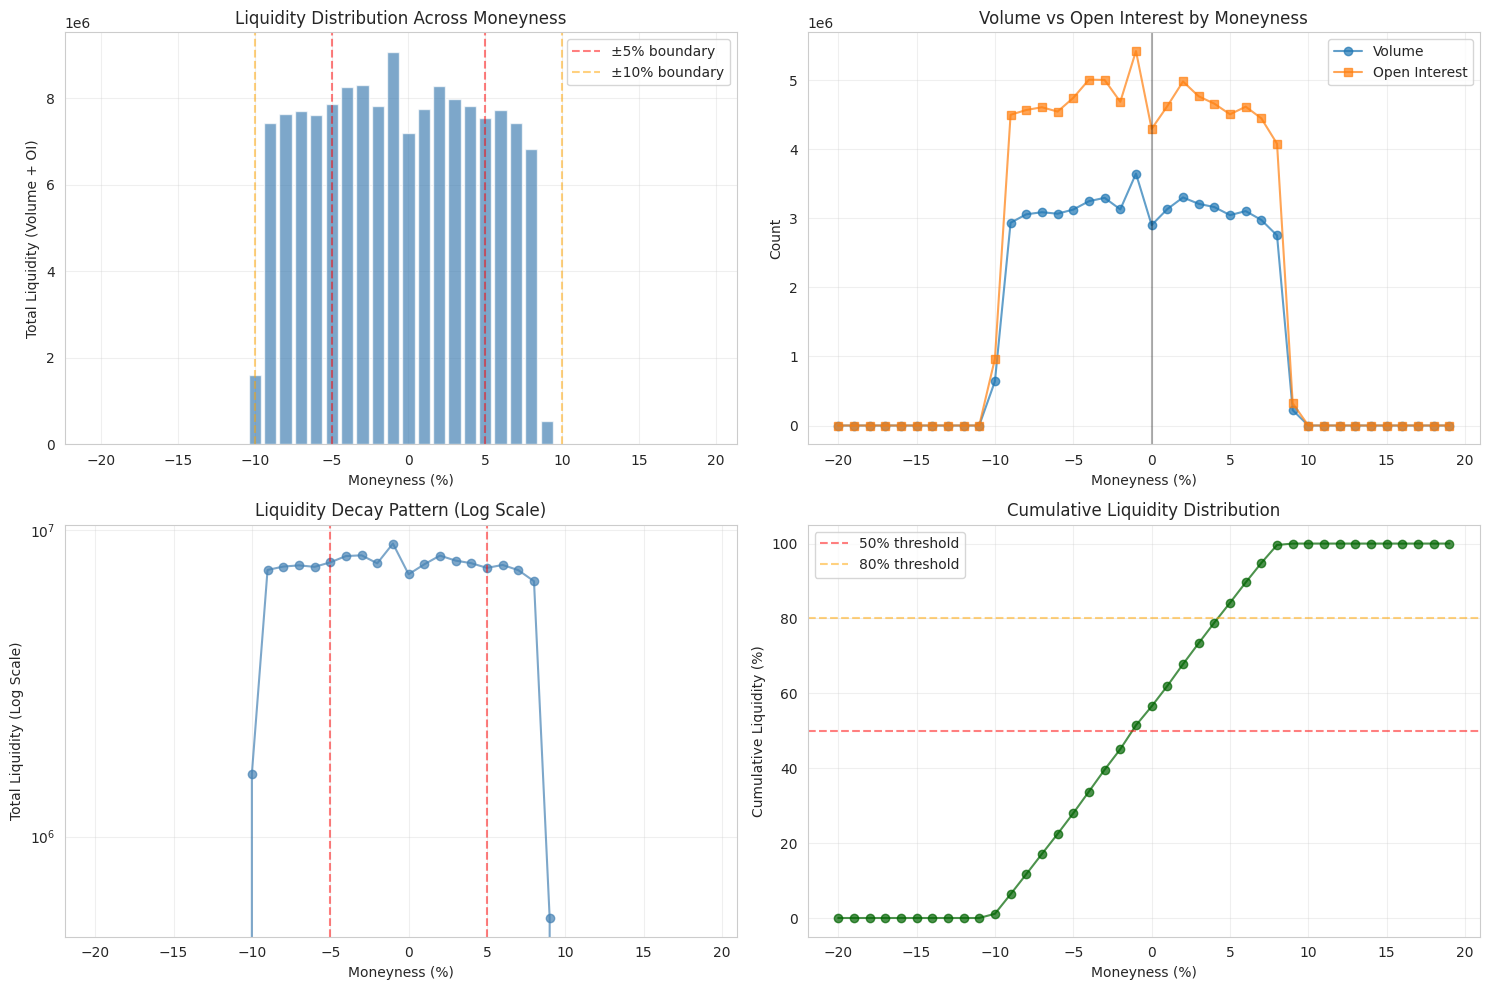


✓ Evidence: 56.4% of liquidity within ±5% moneyness
  → Strike smoothness assumption MODERATE beyond ATM region

TEST 2: OTM LIQUIDITY QUALITY

Bid-Ask Spread Analysis by Moneyness:
                   spread_pct              strike
                         mean median   std  count
moneyness_category                               
ATM (0-5%)               2.10   2.10  0.06  31376
Near OTM (5-10%)         2.28   2.28  0.05  26136
Mid OTM (10-15%)          NaN    NaN   NaN      0
Deep OTM (>15%)           NaN    NaN   NaN      0

Spread Inflation Factor (Deep OTM / ATM): nanx


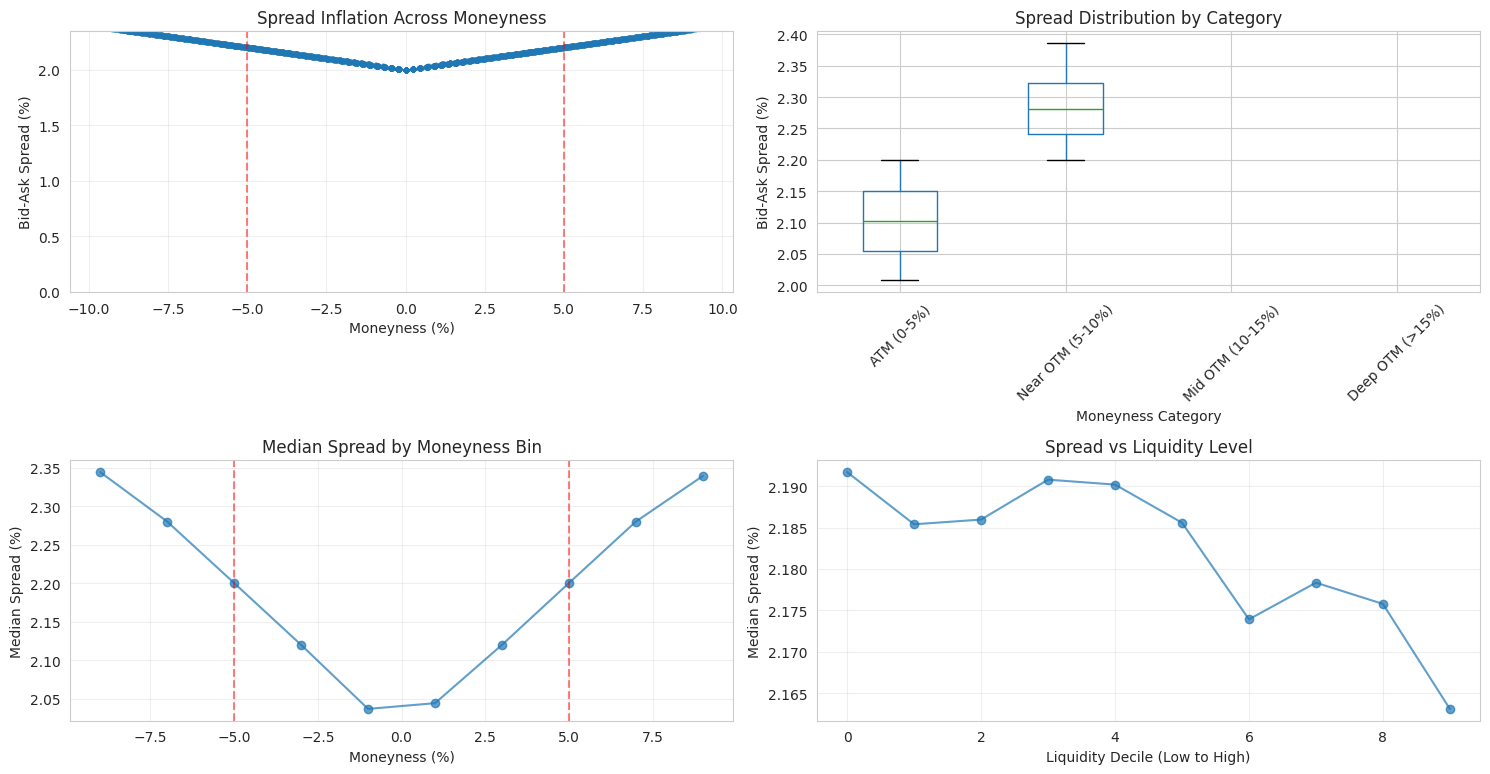


✓ Evidence: nanx spread inflation in deep OTM
  → Noisy inputs into variance estimation from OTM region

TEST 3: STRIKE CONTINUITY GAP DETECTION

Strike Gap Statistics:
  Mean gap: 0.227%
  Median gap: 0.227%
  Std dev: 0.006%
  Max gap: 0.241%
  Gaps > 1%: 0 (0.0%)
  Gaps > 2%: 0 (0.0%)


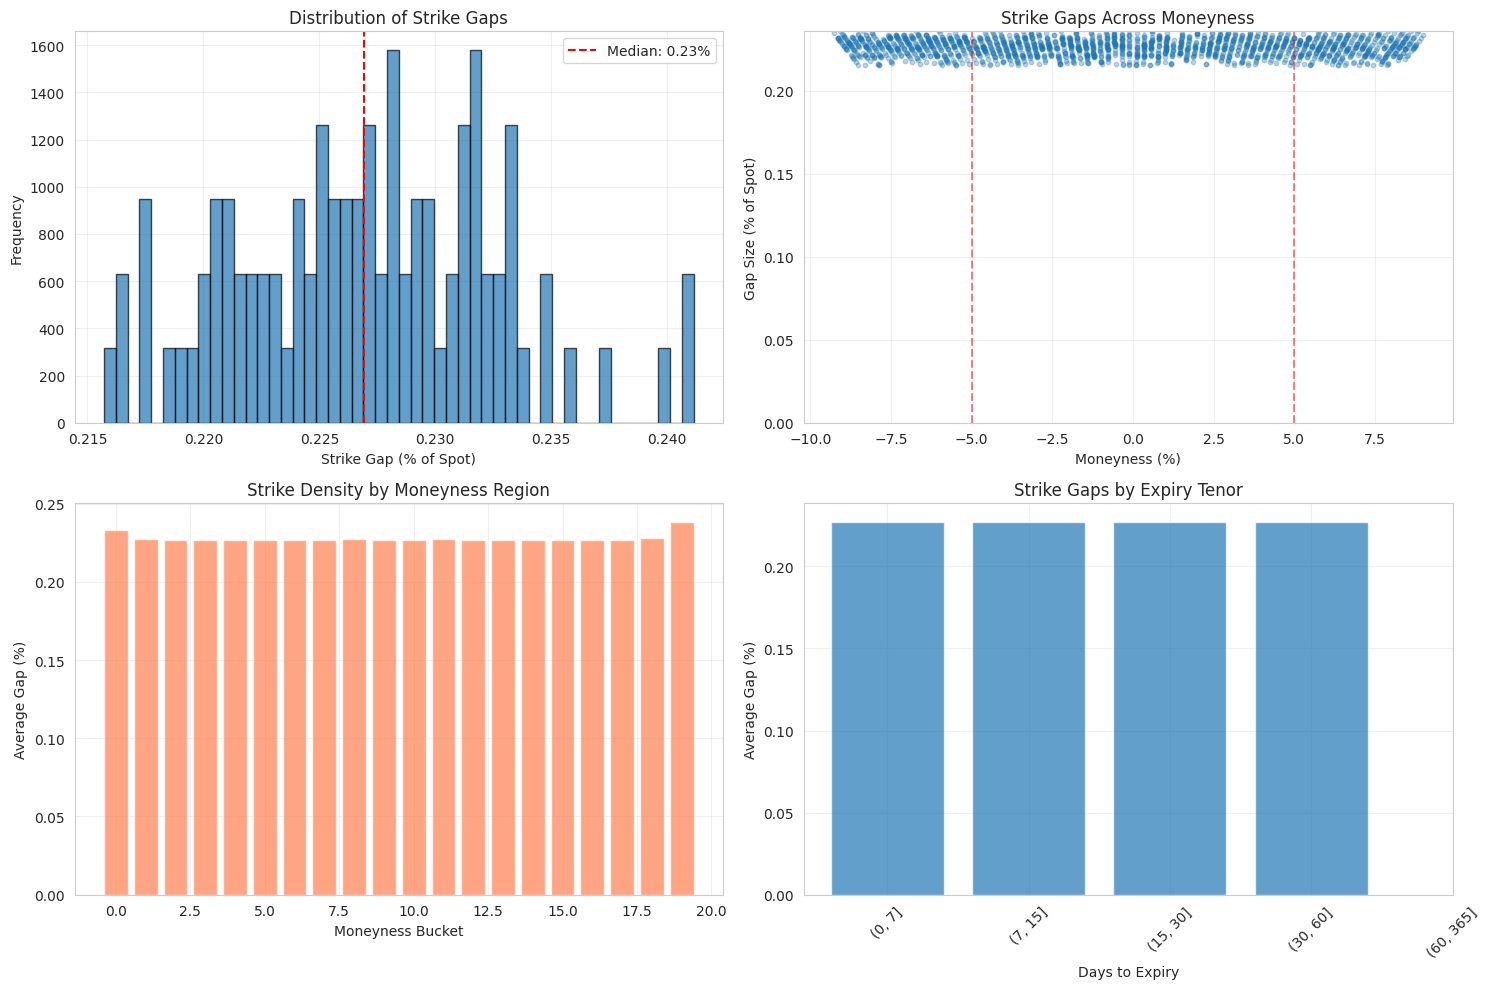


✓ Evidence: Discrete strike grid with irregular spacing
  → Imperfect variance replication from discrete approximation

TEST 4: SHORT-DATED VOLUME DOMINANCE

Volume Distribution by DTE Category:
  0-7 DTE:   25.1% (±1.3%)
  8-30 DTE:  50.0% (±1.6%)
  >30 DTE:   25.0% (±1.2%)


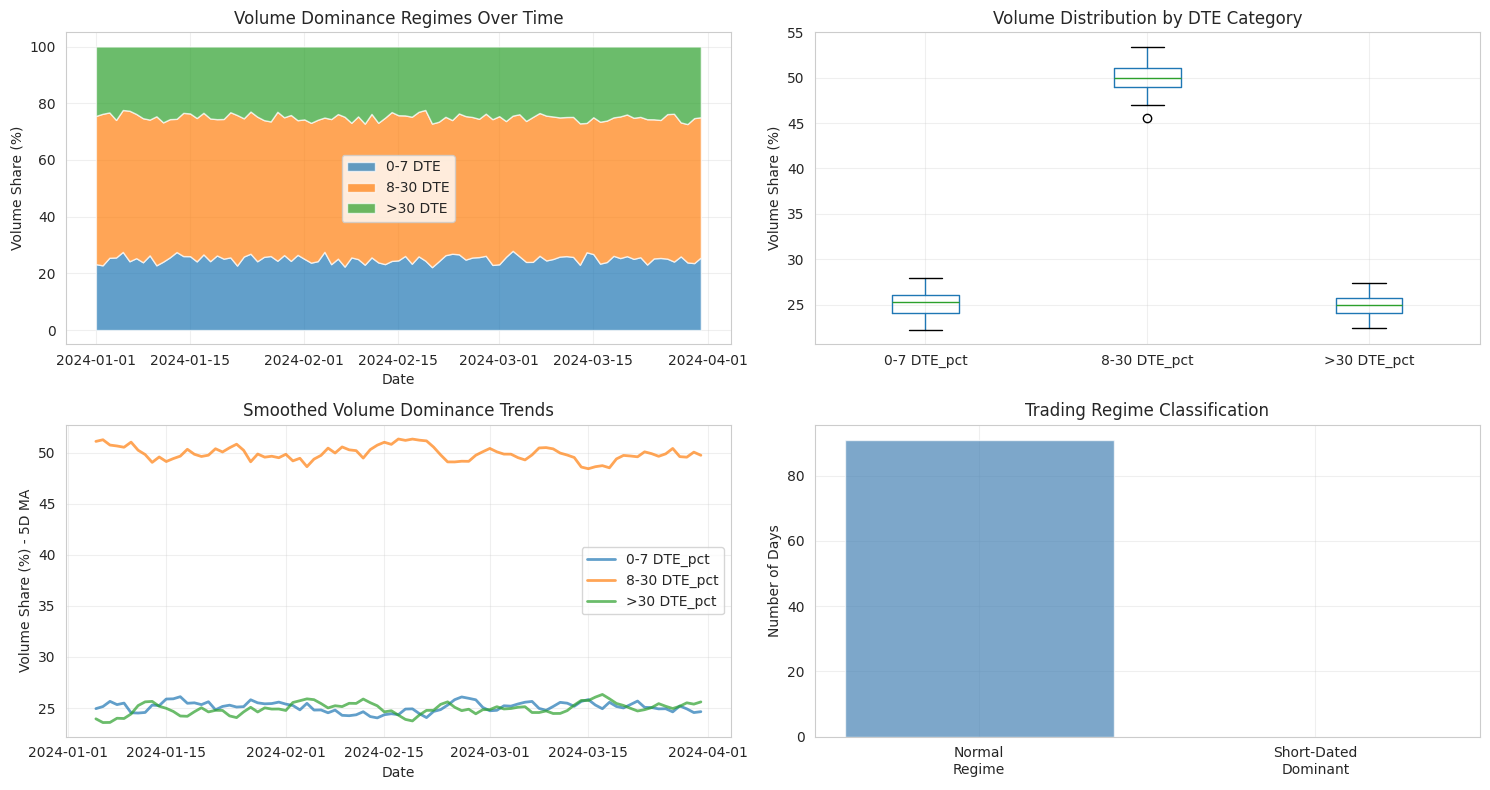


✓ Evidence: 25.1% average volume in 0-7 DTE
  → Variance reflects short-term positioning, not long-horizon risk

TEST 5: SYNTHETIC VARIANCE RECONSTRUCTION

Successfully reconstructed variance for 91 days
Mean synthetic VIX: 20.83
Std synthetic VIX: 0.52

Reconstruction Error vs Official VIX:
  Mean error: 5.81 pts
  Mean abs error: 5.88 pts
  RMSE: 6.49 pts
  Correlation: -0.106


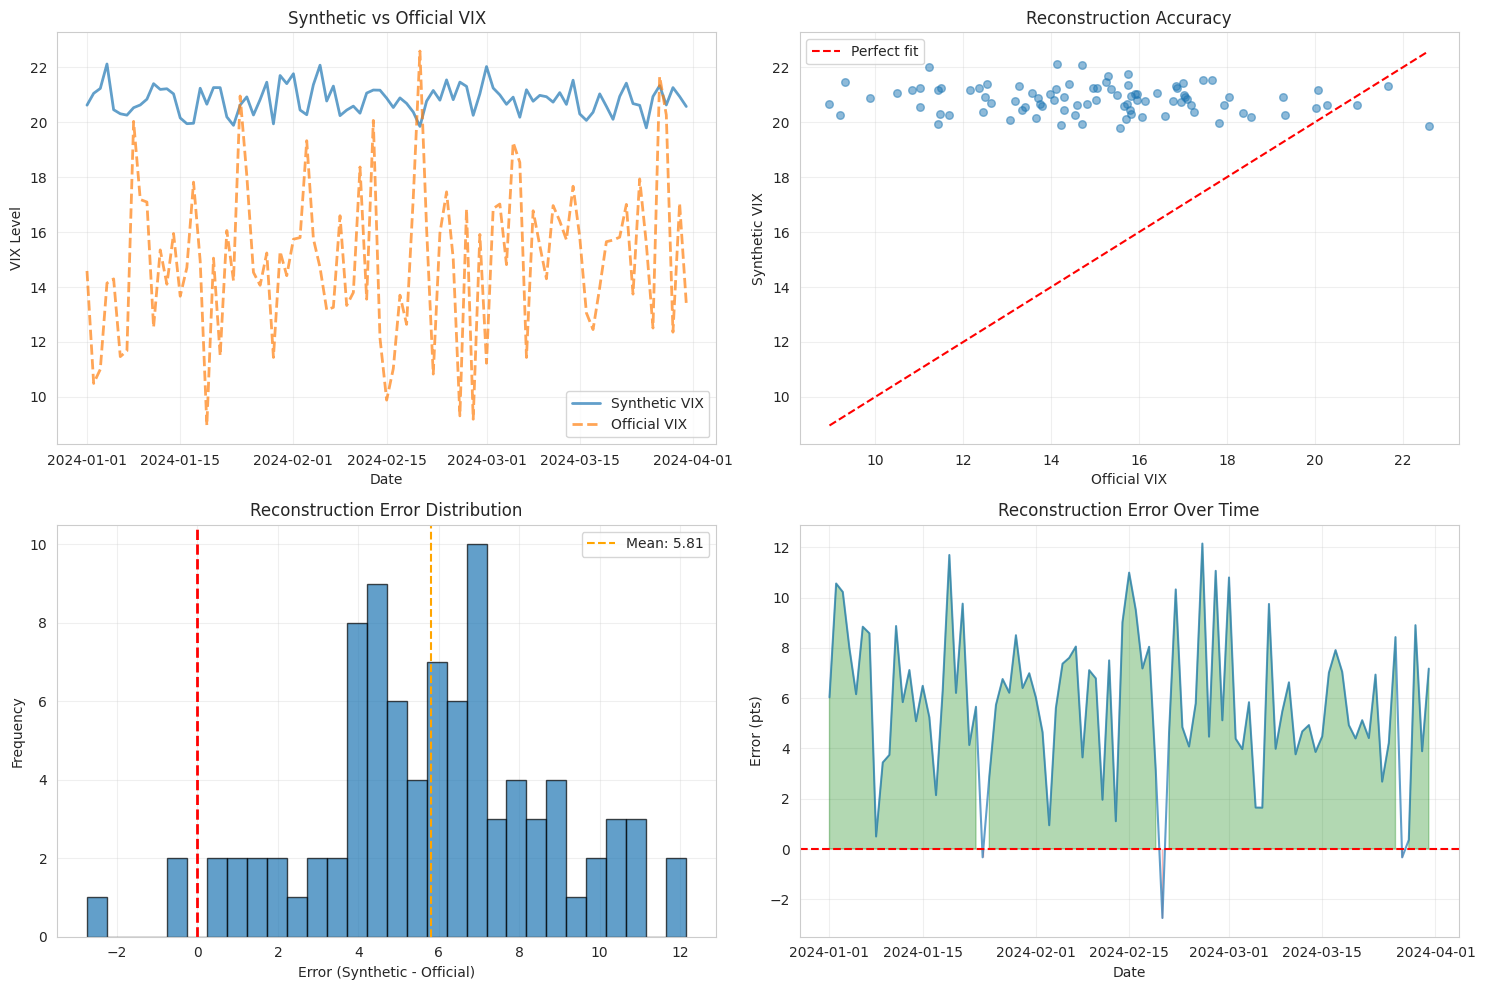


✓ Evidence: Persistent deviation detected
  → Gap between theoretical VIX formula and reported index

TEST 6: REALIZED VOLATILITY FORECAST ERROR

Forecast Error Analysis:
  Mean error: -37.61 pts
  MAE: 37.61 pts
  RMSE: 38.21 pts
  Correlation (Implied vs Realized): -0.144

Forecast Error by Regime:
        Mean Error  Std Error    MAE
regime                              
Normal      -37.61        6.8  37.61


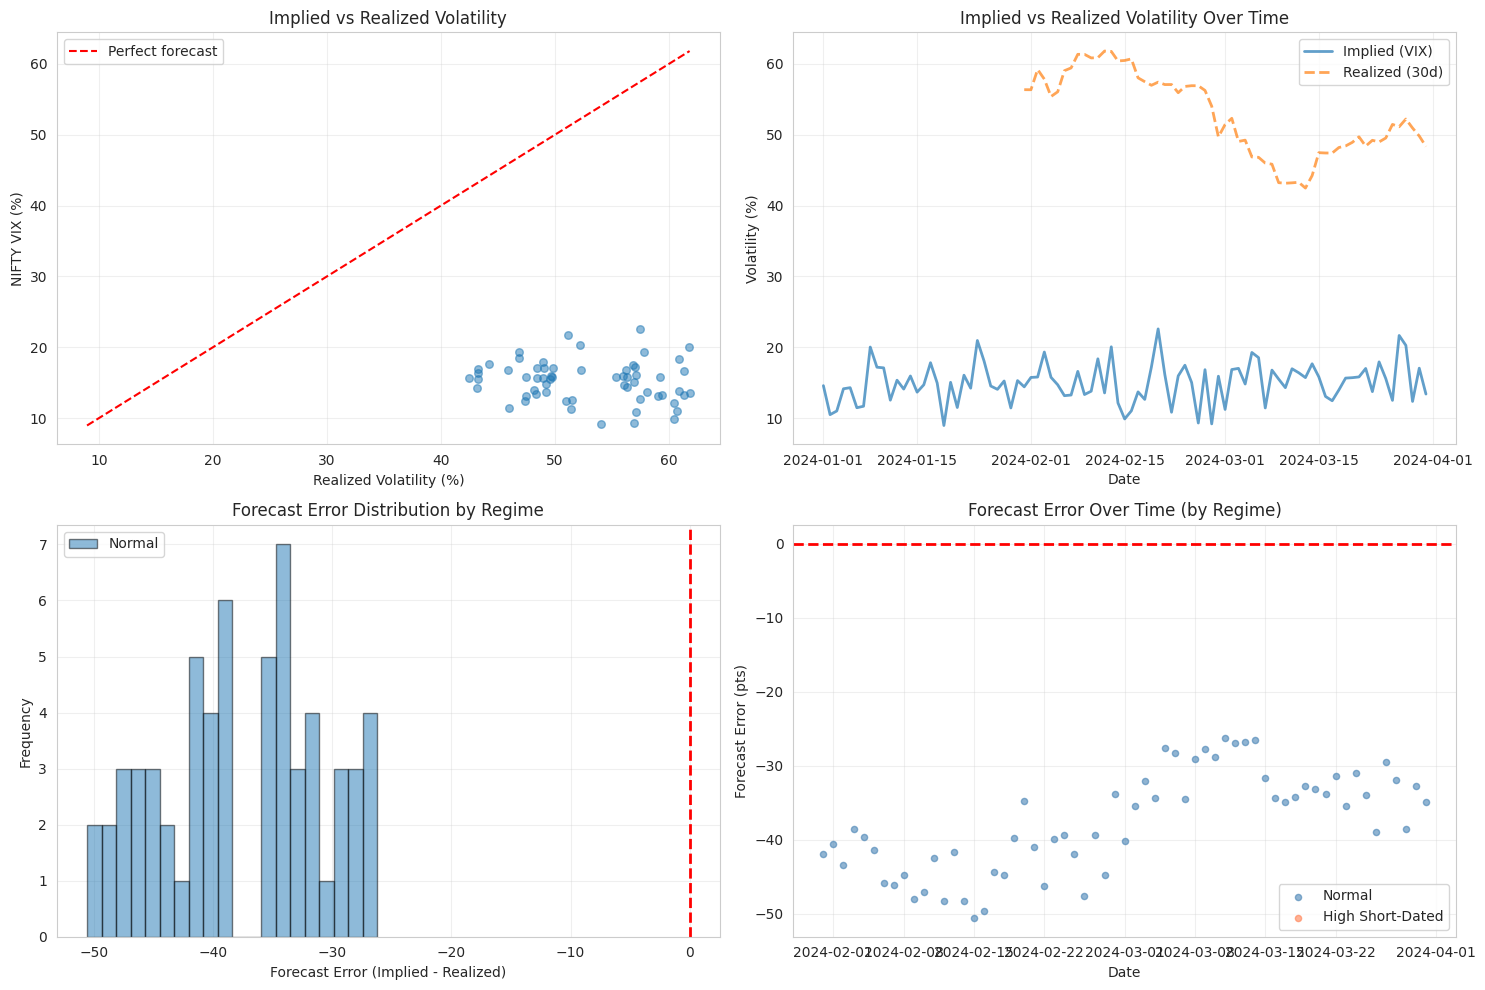

KeyError: 'High Short-Dated'

In [39]:
# Example usage with synthetic data
if __name__ == "__main__":
    print("Generating synthetic NIFTY data for demonstration...\n")

    # Generate synthetic option chain data
    np.random.seed(42)
    dates = pd.date_range('2024-01-01', '2024-03-31', freq='D')
    spot_base = 22000

    synthetic_data = []
    spot_data = []
    vix_data = []

    for date in dates:
        spot = spot_base + np.random.randn() * 500
        spot_data.append({'date': date, 'spot_price': spot})

        # VIX
        vix_data.append({'date': date, 'nifty_vix': 15 + np.random.randn() * 3})

        # Generate strikes around spot
        strikes = np.arange(spot - 2000, spot + 2000, 50)

        for expiry_offset in [7, 15, 30, 60]:
            expiry = date + timedelta(days=expiry_offset)

            for strike in strikes:
                moneyness = (strike - spot) / spot

                # Volume decreases with distance from ATM
                base_volume = max(1000 * np.exp(-10 * moneyness**2), 10)
                volume = int(base_volume * (1 + 0.5 * np.random.randn()))
                oi = int(volume * (1.5 + 0.5 * np.random.randn()))

                # Bid-ask spread increases with OTM
                spread_factor = 1 + 2 * abs(moneyness)
                mid_price = max(50 * np.exp(-5 * moneyness**2), 1)
                spread = mid_price * 0.02 * spread_factor

                for opt_type in ['CE', 'PE']:
                    synthetic_data.append({
                        'date': date,
                        'expiry': expiry,
                        'strike': strike,
                        'option_type': opt_type,
                        'bid': max(mid_price - spread/2, 0.5),
                        'ask': mid_price + spread/2,
                        'last_price': mid_price,
                        'volume': max(volume, 0),
                        'open_interest': max(oi, 0)
                    })

    options_df = pd.DataFrame(synthetic_data)
    spot_df = pd.DataFrame(spot_data)
    vix_df = pd.DataFrame(vix_data)

    print(f"Generated {len(options_df):,} option records")
    print(f"Date range: {dates[0].date()} to {dates[-1].date()}")
    print(f"Spot range: {spot_df['spot_price'].min():.0f} to {spot_df['spot_price'].max():.0f}")
    print(f"Number of unique strikes: {options_df['strike'].nunique()}")
    print(f"Number of expiries per day: {options_df.groupby('date')['expiry'].nunique().mean():.0f}")

    # Initialize testing framework
    print("\nInitializing NIFTY VIX Stress Testing Framework...")
    tester = NIFTYVIXStressTest(
        option_data=options_df,
        spot_data=spot_df,
        vix_data=vix_df
    )

    # Run all tests
    print("\nRunning comprehensive stress tests...\n")
    results = tester.run_all_tests()

    # Display summary statistics
    print("\n" + "="*80)
    print("DATA SUMMARY")
    print("="*80)
    print(f"\nOption Chain Statistics:")
    print(f"  Total records: {len(options_df):,}")
    print(f"  Date range: {len(dates)} days")
    print(f"  Average daily volume: {options_df.groupby('date')['volume'].sum().mean():,.0f}")
    print(f"  Average daily OI: {options_df.groupby('date')['open_interest'].sum().mean():,.0f}")

    print(f"\nMoneyness Distribution:")
    for threshold in [1, 2, 5, 10]:
        pct = (options_df['moneyness_pct'].abs() <= threshold).mean() * 100
        print(f"  Within ±{threshold}%: {pct:.1f}% of strikes")

    print("\n" + "="*80)
    print("All tests completed successfully!")
    print("Check output directory for detailed visualizations.")
    print("="*80)